# Zooplankton biomass
<div>
<img src="https://img.pagecloud.com/dZrHVa1h6KM_DQHq7w-SP_Lk7oo=/462x0/filters:no_upscale()/scientific-illustrations-by-kristen/images/copepod-n260e.png" width="300"/>
</div>

A copepod, a type of zooplankton. Art credit: [Kristen Krumhardt](https://kristenkrumhardtart.com/)

---

## Overview
Zooplankton are tiny oceanic animals, making up the next step up after phytoplankton in the food web. Here we evaluate modeled zooplankton biomass and compare it to observational data.

1. General setup
2. Subsetting
3. Processing - long-term mean
4. Mapping zooplankton biomass at the surface
5. Comparing mesozooplankton biomass to observations
6. Making monthly climatology maps to compare to observations
   

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray) | Helpful | |

- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster
import s3fs

from module import adjust_pop_grid

/free1/ktyle/miniforge_2025/envs/ocean-bgc-cookbook-dev/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

### Load the data

In [4]:
jetstream_url = 'https://js2.jetstream-cloud.org:8001/'

s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=jetstream_url))

# Generate a list of all files in CESM folder
s3path = 's3://pythia/ocean-bgc/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1/*'
remote_files = s3.glob(s3path)
s3.invalidate_cache()

# Open all files from folder
fileset = [s3.open(file) for file in remote_files]

# Open with xarray
ds = xr.open_mfdataset(fileset, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)

ds

<xarray.Dataset> Size: 28GB
Dimensions:                         (time: 120, nlat: 384, nlon: 320, z_t: 60,
                                     z_t_150m: 15)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                            (time) object 960B 2010-01-16 12:00:00 .....
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/45)
    FG_CO2                          (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    Fe                              (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    NO3                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    PO4                             (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    POC_FLUX_100m                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    SALT                            (time, z_t, nlat, nlon) float32 4GB dask.array<chunksize=(30, 15, 96, 80), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 59MB dask.array<chunksize=(60, 192, 160), meta=np.ndarray>

## Subsetting

In [5]:
variables =['mesozooC', 'microzooC']

In [6]:
keep_vars=['z_t','z_t_150m','dz','time_bound','time','TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Processing - long-term mean

Pull in the function we defined in the nutrients notebook...

In [7]:
def year_mean(ds):
    """
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.year'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each year is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")

In [8]:
# Take the long-term mean of our data set, processing years and months separately

ds_annual = year_mean(ds).mean("year")

## Plot mesozooplankton and microzooplankton biomass at the surface

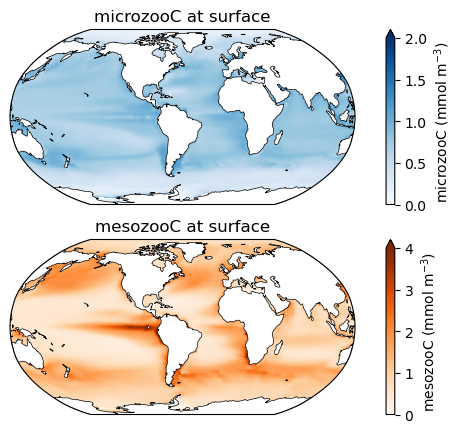

In [9]:
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('microzooC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_annual.microzooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Blues',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='microzooC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('mesozooC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds_annual.mesozooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Oranges',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mesozooC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

## Compare mesozooplankton biomass to COPEPOD database

We use data compiled through the COPEPOD project [(Moriarty & O'Brien, 2013)](https://doi.org/10.5194/essd-5-45-2013). This data has been pre-processed, but the raw data is available on the [COPEPOD website](https://www.st.nmfs.noaa.gov/copepod/about/databases.html).

### Read in COPEPOD data

In [10]:
copepod_obs_path = 's3://pythia/ocean-bgc/obs/copepod-2012__cmass-m00-qtr.zarr'

copepod_obs = s3fs.S3Map(root=copepod_obs_path, s3=s3)

ds_copepod = xr.open_dataset(copepod_obs, engine="zarr")

### converting grams to moles
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

In [11]:
ds_copepod

<xarray.Dataset> Size: 17MB
Dimensions:    (lat: 720, lon: 1440)
Coordinates:
  * lat        (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    copepod_C  (lat, lon) float64 8MB nan nan nan nan nan ... nan nan nan nan
    n_obs      (lat, lon) float64 8MB ...
Attributes:
    file_in:  data/orig/copepod-2012__biomass-fields/data/copepod-2012__cmass...

### Plot

<>:10: SyntaxWarning: invalid escape sequence '\i'
<>:10: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_23380/3097243711.py:10: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)


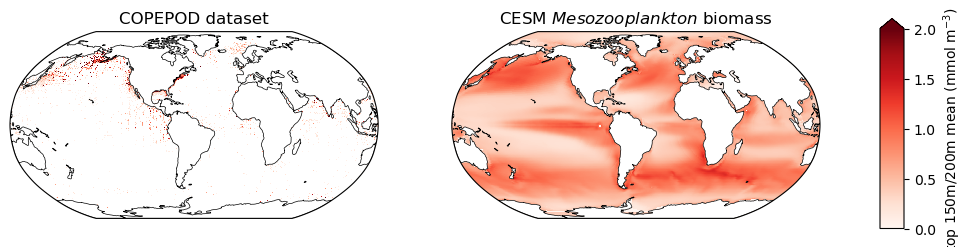

In [12]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
pc=ax.pcolormesh(ds_copepod.lon, ds_copepod.lat, ds_copepod.copepod_C, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds_annual.mesozooC.mean(dim='z_t_150m'))
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)');

## Making monthly climatology maps to compare to observations

### Compare to observation-based GLMM (Generalized Linear Mixed Model) of global mesozooplankton biomass climatology 
This data is from [Heneghan et al., 2020](https://doi.org/10.1016/j.ecolmodel.2020.109265), which includes the COPEPOD dataset we used previously as well as additional observations, with some pre-processing.

In [13]:
mesozoo_obs_path = 'data/obsglmm_zmeso_vint_200m_monthly_climatology.nc'

ds_copepod_clim = xr.open_dataset(mesozoo_obs_path)
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

### Make our CESM data into a monthly climatology

In [14]:
mon_ds = ds.copy()
mon_ds = ds.groupby('time.month').mean('time')

In [15]:
### depth integrate and convert model to mg C/m2
mon_ds['mesozooC_zint'] = ((mon_ds.mesozooC) * 10.).sum(dim='z_t_150m') #in mmol/m2
mon_ds['mesozooC_zint'] = mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

### Plot

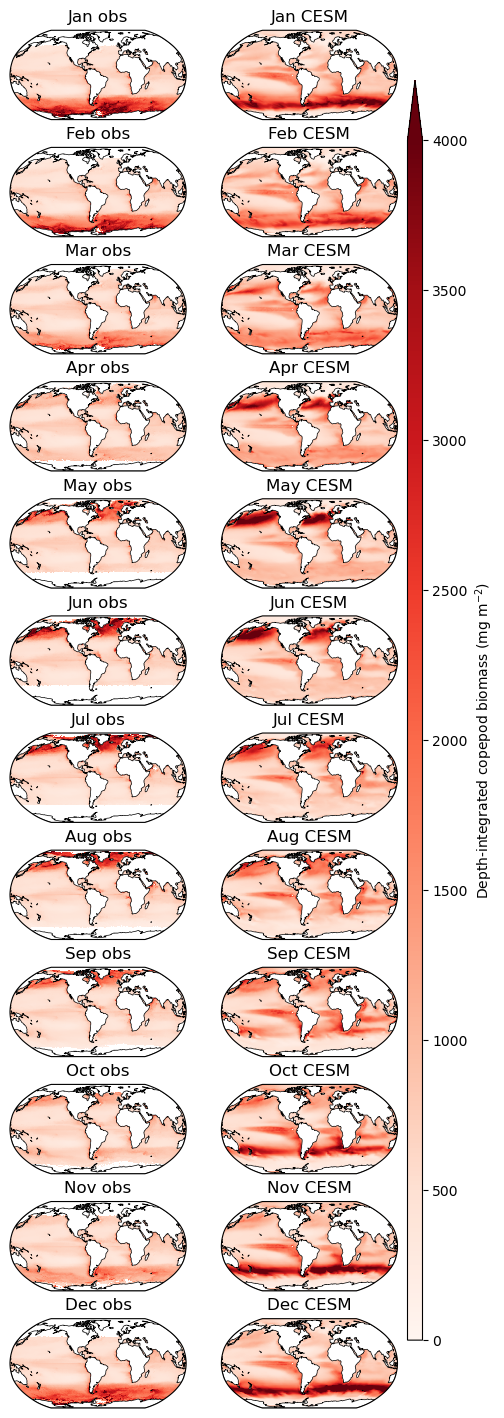

In [16]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = mon_ds.mesozooC_zint.isel(month=ts)
    lon, lat, field = adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
    ax.add_feature(land)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

And close the Dask cluster we spun up at the beginning.

In [17]:
cluster.close()

---

## Summary
You've learned how to evaluate zooplankton biomass modeled by CESM-MARBL and compare it to observations.

## Resources and references
- [Moriarty & O'Brien, 2013](https://doi.org/10.5194/essd-5-45-2013)
- [Petrik et al., 2022](https://doi.org/10.1029/2022GB007367)
- [Heneghan et al., 2020](https://doi.org/10.1016/j.ecolmodel.2020.109265)